# Автоматическая обработка текстов

## Екатерина Черняк

###  ФКН НИУ ВШЭ

### echernyak@hse.ru

# Введение

## Краткая история 

теоретическая лингвистика – корпусная лингвистика – ML & DL эра

## Основные задачи
* Машинный перевод
* Классификация текстов
    * Фильтрация спама
    * По тональности
    * По теме или жанру
* Кластеризация текстов
* Извлечение информации
    * Фактов и событий
    * Именованных сущностей
* Вопросно-ответные системы
* Суммаризация текстов
* Генерация текстов
* Распознавание речи
* Проверка правописания
* Оптическое распознавание символов
* Пользовательские эксперименты и оценка точности и качества методов

## Основные техники 
* Уровень символов:
    * Токенизация: разбиение текста на слова
    * Разбиение текста на предложения
* Уровень слов – морфология:
    * Разметка частей речи
    * Снятие морфологической неоднозначности
* Уровень предложений – синтаксис:
    * Выделенние именных или глагольных групп (chunking)
    * Выделенние семантических ролей
    * Деревья составляющих и зависимостей
* Уровень смысла – семантика и дискурс:
    * Разрешение кореферентных связей
    * Выделение синонимов
    * Анализ аргументативных связей

## Основные проблемы
* Неоднозначность
    * Лексическая неоднозначность: *орган, парить, рожки, атлас*
    * Морфологическая неоднозначность: *Хранение денег в банке. Что делают белки в клетке?*
    * Синтаксическая неоднозначность: *Мужу изменять нельзя. Его удивил простой солдат.*
* Неологизмы: *печеньки, заинстаграммить, репостнуть, расшарить, затащить, килорубли*
* Разные варианты написания: *Россия, Российская Федерация, РФ*
* Нестандартное написание: *каг дила?*

![pipeline](nlp_pipeline.jpg)

### Синтаксическая неоднозначность 
![синтаксическая неоднозначность](http://78.media.tumblr.com/d6552ff51881937371c94dc18865d711/tumblr_mo1nl6Nt9n1rwewyjo1_400.jpg)


* I saw the man. The man was on the hill. I was using a telescope.
* I saw the man. I was on the hill. I was using a telescope.
* I saw the man. The man was on the hill. The hill had a telescope.
* I saw the man. I was on the hill. The hill had a telescope.
* I saw the man. The man was on the hill. I saw him using a telescope.

# План
1. Предварительная обработка текстов: регулярные выражения и POS тэггинг
2. Извлечение ключевых слов и синтаксический анализ 
3. Векторная модель, модели скрытых тем
4. Векторная модель, дистрибутивная семантика
5. Классификация текстов
6. Языковые модели 
7. Извлечение информации
8. Сбор и разметка данных

## План на сегодня
1. Как разбить текст на слова? 
2. Как посчитать количество слов?
3. Все ли слова нужны? Удаление стоп-слов.
4. Как определить часть речи слова. 

Инструменты: регулярные выражения, nltk, pymorphy2, pymystem3 

# Токенизация и подсчет количества слов


## Сколько слов в этом предложении?
* На дворе трава, на траве дрова, не руби дрова на траве двора.*

** 12 токенов** : На, дворе, трава, на, траве, дрова, не, руби, дрова, на, траве, двора

** 8 - 9 типов** : Н/на, дворе, трава, траве, дрова, не, руби, двора. 

** 6  лексем** : на, не, двор, трава, дрова, рубить


### Токен и тип

**  Тип **  – уникальное слово из текста

** Токен **  – тип и его позиция в тексте




### Обозначения 
$N$ = число токенов

$V$ – словарь (все типы)

$|V|$ = количество типов в словаре

** Как связаны $N$ и $|V|$?**


### Закон Ципфа


В любом достаточно большом тексте ранг типа обратно пропорционален его частоте: $f = \frac{a}{r}$

$f$ – частота типа, $r$  – ранг типа, $a$  – параметр, для славянских языков – около 0.07


### Закон Хипса

С увеличением длины текста (количества токенов), количество типов увеличивается в соответствии с законом: $|V| = K*N^b$


$N$  –  число токенов, $|V|$  – количество типов в словаре, $K, b$  –  параметры, обычно $K \in [10,100], b \in [0.4, 0.6]$

# Анализ  сообщений vk.com

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

df = pd.read_csv('../data/vk_texts_with_sources.csv', usecols = ['text', 'source'])

df.text.dropna(inplace = True)
df.head()



,text,source
0,Начальник Главного оперативного управления Ген...,mil
1,Артиллерийские подразделения общевойскового об...,mil
2,Подразделения морской пехоты Каспийской флотил...,mil
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil
4,На большом учебно-методическом командирском сб...,mil


## Предварительный анализ коллекции

### Средняя длина текстов

In [3]:
len_data = df.text.apply(len)
len_data.describe()

count    11526.000000
mean       690.763057
std        749.943222
min          8.000000
25%        186.000000
50%        508.500000
75%        944.000000
max      13306.000000
Name: text, dtype: float64

### Количество текстов из разных пабликов

In [4]:
import matplotlib.pyplot as plt
import numpy as np 
counts = df.source.value_counts()
values = counts.tolist()
labels = counts.index.tolist()


y_pos = np.arange(len(labels))

 
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, range(len(labels)))

 
plt.show()

### Длины текстов (в символах)

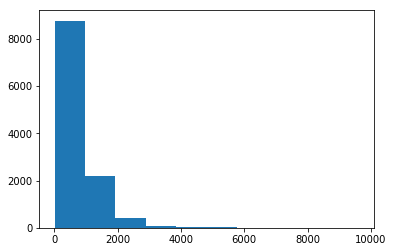

In [5]:
fig, ax = plt.subplots()

length = len_data[len_data < 10000].tolist()

n, bins, patches = ax.hist(length)

fig.show()

## Токенизация

Используем регулярные выражения, чтобы разбить тексты на слова

In [6]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df.text = df.text.str.lower()
df.text = df.text.apply(words_only)

df.text.iloc[0]

'начальник главного оперативного управления генерального штаба вооруженных сил рф генерал полковник сергей рудской провел брифинг для сми по ситуации в сирии с начала этого года сирийскими правительственными войсками при поддержке вкс россии достигнуты значительные успехи по освобождению ключевых районов сирии от остатков террористических группировок это восточная часть провинции идлиб пригороды дамаска восточная гута восточный каламун ярмук северные районы провинции хомс которые в настоящее время находятся полностью под контролем правительственных войск в январе феврале в восточной части провинции идлиб была окружена и уничтожена крупная группировка джабхат ан нусра численностью более боевиков а также разрозненные бандгруппы игиловцев в результате под контроль правительственных войск перешла территория от кафер аккара до саббура с севера на юг и от синджара до эль хаммам с запада на восток площадью более четырех тысяч квадратных километров в настоящее время возобновлено движение по до

### Самые частые слова

In [7]:
from nltk import FreqDist
n_types = []
n_tokens = []
tokens = []
fd = FreqDist()
for index, row in df.iterrows():
    tokens = row['text'].split()
    fd.update(tokens)
    n_types.append(len(fd))
    n_tokens.append(sum(fd.values()))
for i in fd.most_common(10):
    print(i)

('в', 39552)
('и', 29656)
('на', 17274)
('по', 14798)
('с', 11919)
('россии', 9444)
('мвд', 6215)
('из', 4855)
('для', 4635)
('а', 4117)


### Закон Ципфа

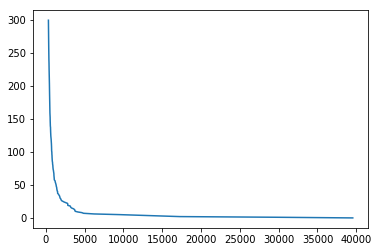

In [8]:
freqs = list(fd.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Закон Хипса

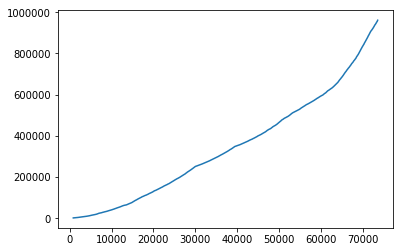

In [9]:
fig, ax = plt.subplots()
ax.plot(n_types, n_tokens)
plt.show()


##  Регулярные выражения подробнее


__*Классы символов:*__

__[A-Z]__ – символы верхнего регистра (латиница)

__[a-z]__ – символы нижнего регистра (латиница)

__[А-Я]__ – символы верхнего регистра (кириллица)

__[а-я]__ – символы нижнего регистра (кириллица)

__[0-9]__ или __\d__ – цифра

__[^0-9]__ или __\D__ – любой символ, кроме цифры

__.__ – любой символ



__*Служебные символы:*__

__\t__ – табуляция

__\s__ – любой пробельный символ

__\S__ – все символы, кроме пробельных

__\n__  – перенос строки

__^__ – начало строки

__$__ – конец строки

__\__ – экранирование

__*Операторы:*__

__?__ - предыдущий символ/группа может быть, а может не быть

__+__ - предыдущий символ/группа может повторяться 1 и более раз

__*__ - предыдущий символ/группа может повторяться 0 и более раз

__{n,m}__ - предыдущий символ/группа может повторяться от от n до m включительно

__{n,}__ - предыдущий символ/группа в скобках может повторяться n и более раз

__{,m}__ - предыдущий символ/группа может повторяться до m раз

__{n}__ - предыдущий символ/группа повторяется n раз

Внутри групп не работают операторы __.__, __+__, __*__, их необходимо экранировать с помощью обратного слеша: \



__*Методы:*__

__re.match(pattern, string)__ - найти подстроку pattern в начале строки string



In [10]:
import re

m = re.match(r'рыбак', 'рыбак рыбака видит издалека')

print(m)
print(m.group(0))
print(m.start(), m.end())

l = re.match(r'видит', 'рыбак рыбака видит издалека')
print(l)

<_sre.SRE_Match object; span=(0, 5), match='рыбак'>
рыбак
0 5
None



__re.search(pattern, string)__ - аналогичен методу match, но ищет не только в начале строки (но возвращает только первое вхождение!)




In [11]:
m = re.search(r'издалека', 'рыбак рыбака видит издалека')

print(m)
print(m.group(0))
print(m.start(), m.end())

l = re.search(r'прорубь', 'рыбак рыбака видит издалека')
print(l)

<_sre.SRE_Match object; span=(19, 27), match='издалека'>
издалека
19 27
None


__re.findall(pattern, string)__ -  возвращает все вхождения pattern в string в виде списка

In [12]:
m = re.findall(r'рыбак', 'рыбак рыбака видит издалека')

print(m)

l = re.findall(r'прорубь', 'рыбак рыбака видит издалека')
print(l)

['рыбак', 'рыбак']
[]


__re.split(pattern, string, [maxsplit=0])__ - разделяет строку string по шаблону pattern; параметр maxsplit отвечает за максимальное количество разбиений (если их существует несколько).




In [13]:
m = re.split(r'видит', 'рыбак рыбака видит издалека')

print(m)

l = re.split(r'рыбак', 'рыбак рыбака видит издалека')
print(l, len(l))

l1 = re.split(r'рыбак', 'рыбак рыбака видит издалека',maxsplit=1)
print(l1, len(l1))

['рыбак рыбака ', ' издалека']
['', ' ', 'а видит издалека'] 3
['', ' рыбака видит издалека'] 2


__re.sub(pattern, string2, string1)__ - заменяет все вхождения pattern в string1 на srting2




In [14]:
m = re.sub(r'рыбак', 'Рыбак', 'рыбак рыбака видит издалека')

print(m)

Рыбак Рыбака видит издалека


__re.compile(pattern)__ - создает объект для последующего поиска

In [15]:
prog = re.compile(r'рыбак')

m = prog.findall('рыбак рыбака видит издалека')

print(m)

['рыбак', 'рыбак']


In [16]:
prog = re.compile('[А-Я]') # поиск всех заглавныех букв в строке

m = prog.findall('Рыбак рыбака видит издалека. Всегда!')

print(m)

['Р', 'В']


In [17]:
prog = re.compile('[авекорсту]{1}[0-9]{3}[авекорсту]{2}') # регулярное выражение для поиска автомобильных
                                                          # номеров (русские буквы, совпадающие с латиницей)

s = 'у456ао, ы234ег, 99авто443'
print(s)
res = prog.findall(s)

print(*res)

у456ао, ы234ег, 99авто443
у456ао


In [18]:
# пример "жадных" операторов: ищем котов

s = 'кот котик компот'
res1 = re.findall(r'к.*т', s)
print(res1)

res2 = re.findall(r'к.*?т', s)
print(res2)

res3 = re.findall(r'к[\S]*?т', s)
print(res3)

res4 = re.findall(r'кот.*\s', s)
print(res4)

['кот котик компот']
['кот', 'кот', 'к компот']
['кот', 'кот', 'компот']
['кот котик ']


### __Задание 1__

Найдите в тексте все номера телефонов; текст лежит в файле 'task1.txt'. Обратите внимание на возможные форматы написания номеров.

In [19]:
import re

with open ('../data/task1.txt', encoding='utf8') as f:
    phones = f.read()
    
print(phones)

#здесь Ваш код

Гарантируется, что в номере 11 цифр и он отделен пробелом, но форматы написания могут отличаться:


89268659970	Анна
8(495)3451212	Алексей Иванин
Автомастерская	+7(234)456-78-90
8(956)234-23-23	соседка 125 квартира
Офис, 5 этаж	85679962312 
Игорь		+7-845-344-23-65



### Сегментация предложений

"?", "!" как правило однозначны. Проблемы возникают с ".".

Бинарный классификатор для сегментации предложений: для каждой точки "." определить, является ли она концом предложения или нет.


In [20]:
from nltk.tokenize import sent_tokenize

text = 'Первое предложение. Второе предложение! И, наконец, третье?'
sents = sent_tokenize(text)

print(len(sents))
print(*sents, sep='\n')

3
Первое предложение.
Второе предложение!
И, наконец, третье?


In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/katya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### __Задание 2__

Посчитайте количество предложений, токенов и типов в тексте из файла task2.txt. Сохраните список токенов в массив tokens.

In [22]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

## __Частотный анализ текста__

In [23]:
import nltk

d1 = nltk.FreqDist(tokens) # частотный словарь для текста
d1.most_common(10) # токен и кол-во его появлений в тексте

[]

### Задание 3

1. Посчитайте, сколько слов в тексте task2 встречается больше одного раза.
2. Посчитайте количество слов, состоящих из 5 букв и более.

# Морфологический анализ

### Задачи морфологического анализа
* Разбор слова — определение нормальной формы  (леммы), основы (стема) и грамматических характеристик слова
* Синтез слова — генерация слова по заданным грамматическим характеристикам


### Морфологический процессор – инструмент морфологического анализа
* Морфологический словарь 
* Морфологический анализатор

### Лемматизация 
У каждого слова есть *лемма* (нормальная форма): 

* кошке, кошку, кошкам, кошкой $\implies$ кошка
* бежал, бежит, бегу $\implies$  бежать
* белому, белым, белыми $\implies$ белый

In [24]:
sent1 = 'Действительно, на его лице не отражалось никаких чувств – ни проблеска сочувствия не было на нем, а ведь боль просто невыносима'
sent2 = 'У страха глаза велики .'

In [25]:
from pymorphy2 import MorphAnalyzer

m = MorphAnalyzer()
lemmas1 = [m.parse(word)[0].normal_form for word in sent1.split()]
print(' '.join(lemmas1))

действительно, на он лицо не отражаться никакой чувство – ни проблеск сочувствие не быть на нем, а ведь боль просто невыносимый


In [26]:
from pymystem3 import Mystem

m = Mystem()
lemmas2 = m.lemmatize(sent1)
print(''.join(lemmas2))

действительно, на его лицо не отражаться никакой чувство – ни проблеск сочувствие не быть на немой, а ведь боль просто невыносимый



### Стемминг
Слова состоят из морфем: $word = stem + affixes$. Стемминг позволяет отбросить аффиксы. Чаще всего используется алгоритм Портера.

* 1-ый вид ошибки: белый, белка, белье $\implies$  бел

* 2-ой вид ошибки: трудность, трудный $\implies$  трудност, труд 

* 3-ий вид ошибки: быстрый, быстрее $\implies$  быст, побыстрее $\implies$  побыст

Алгоритм Портера состоит из 5 циклов команд, на каждом цикле – операция удаления / замены суффикса. Возможны вероятностные расширения алгоритма.


In [27]:
from nltk.stem.snowball import RussianStemmer

stemmer = RussianStemmer()
words = ['распределение', 'приставить', 'сделала', 'словообразование']
for w in words:
    stem = stemmer.stem(w)
    print(stem)

распределен
пристав
сдела
словообразован


### Разбор слова 

In [28]:
word1 = 'ГАИ'

In [29]:
m = MorphAnalyzer()
m.parse(word1)

[Parse(word='гаи', tag=OpencorporaTag('NOUN,anim,masc,Name plur,nomn'), normal_form='гай', score=0.1111111111111111, methods_stack=((<DictionaryAnalyzer>, 'гаи', 41, 6),)),
 Parse(word='гаи', tag=OpencorporaTag('NOUN,inan,masc plur,nomn'), normal_form='гай', score=0.1111111111111111, methods_stack=((<DictionaryAnalyzer>, 'гаи', 495, 7),)),
 Parse(word='гаи', tag=OpencorporaTag('NOUN,inan,masc plur,accs'), normal_form='гай', score=0.1111111111111111, methods_stack=((<DictionaryAnalyzer>, 'гаи', 495, 10),)),
 Parse(word='гаи', tag=OpencorporaTag('NOUN,inan,femn,Sgtm,Fixd,Abbr,Orgn sing,nomn'), normal_form='гаи', score=0.1111111111111111, methods_stack=((<DictionaryAnalyzer>, 'гаи', 645, 0),)),
 Parse(word='гаи', tag=OpencorporaTag('NOUN,inan,femn,Sgtm,Fixd,Abbr,Orgn sing,gent'), normal_form='гаи', score=0.1111111111111111, methods_stack=((<DictionaryAnalyzer>, 'гаи', 645, 1),)),
 Parse(word='гаи', tag=OpencorporaTag('NOUN,inan,femn,Sgtm,Fixd,Abbr,Orgn sing,datv'), normal_form='гаи', scor

In [30]:
m = Mystem()
m.analyze(word1)

[{'analysis': [{'gr': 'S,сокр,ед,жен,неод=(пр|вин|дат|род|твор|им)',
    'lex': 'гаи'}],
  'text': 'ГАИ'},
 {'text': '\n'}]

### Задание 4

Найдите в списке персонажей романа "Война и мир"  (task3.txt) все уникальные  женские имена.

## Первичная обработка текстов

### Удаление стоп-слов

In [31]:
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [32]:
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
 

In [33]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [34]:
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""


In [35]:
df.text = df.text.apply(remove_stopwords) 
df.text = df.text.apply(lemmatize)
df.text = df.text.apply(remove_stoplemmas) 

In [36]:
lemmata = []
for index, row in df.iterrows():
    lemmata += row['text'].split()
fd = FreqDist(lemmata)
for i in fd.most_common(10):
    print(i)

('россия', 9769)
('мвд', 6215)
('полиция', 6128)
('год', 5826)
('москва', 5286)
('сотрудник', 3857)
('мчс', 3789)
('почтовый', 3772)
('г', 3655)
('почта', 3392)


# Синтаксический анализ


## Грамматика зависимостей

Я купил кофе в большом магазине

![дерево зависимостей](https://habrastorage.org/getpro/geektimes/post_images/67a/b10/baf/67ab10baf90e8f9e321c2e29998e5de8.png)

* Все слова в предложении связаны отношением типа "хозяин-слуга", имеющим различные подтипы
* Узел дерева – слово в предложении
* Дуга дерева – отношение подчинения


[Универсальные зависимости](http://universaldependencies.org/)


### SyntaxNet 

[SyntaxNet](https://github.com/tensorflow/models/tree/master/research/syntaxnet) – архитектура синтаксического парсера. Доступны обученные модели для более чем 40 языков, в том числе, для русского.


D. Chen and C. D. Manning. A Fast and Accurate Dependency Parser using Neural Networks. EMNLP. 2014.

In [42]:
!echo "На северо-западе Москвы два подростка провалились под лед" | docker run --rm -i inemo/syntaxnet_rus

I syntaxnet/term_frequency_map.cc:103] Loaded 34 terms from ./syntaxnet/models/Russian-SynTagRus/label-map.
I syntaxnet/term_frequency_map.cc:103] Loaded 34 terms from ./syntaxnet/models/Russian-SynTagRus/label-map.
I syntaxnet/embedding_feature_extractor.cc:35] Features: input.capitalization input(1).capitalization input(2).capitalization input(3).capitalization input(-1).capitalization input(-2).capitalization input(-3).capitalization input(-4).capitalization; input.token.char-ngram input(1).token.char-ngram input(2).token.char-ngram input(3).token.char-ngram input(-1).token.char-ngram input(-2).token.char-ngram input(-3).token.char-ngram input(-4).token.char-ngram; input.digit input.hyphen input.token.punctuation-amount input.token.quote; input.token.prefix(length=2) input(1).token.prefix(length=2) input(2).token.prefix(length=2) input(3).token.prefix(length=2) input(-1).token.prefix(length=2) input(-2).token.prefix(length=2) input(-3).token.prefix(length=2) input(-4).token.prefix(l

I syntaxnet/term_frequency_map.cc:103] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
I syntaxnet/term_frequency_map.cc:103] Loaded 34 terms from ./syntaxnet/models/Russian-SynTagRus/label-map.
I syntaxnet/embedding_feature_extractor.cc:35] Features: stack.child(1).label stack.child(1).sibling(-1).label stack.child(-1).label stack.child(-1).sibling(1).label stack.child(2).label stack.child(-2).label stack(1).child(1).label stack(1).child(1).sibling(-1).label stack(1).child(-1).label stack(1).child(-1).sibling(1).label stack(1).child(2).label stack(1).child(-2).label; input.token.morphology-set input(1).token.morphology-set input(2).token.morphology-set input(3).token.morphology-set stack.token.morphology-set stack.child(1).token.morphology-set stack.child(1).sibling(-1).token.morphology-set stack.child(-1).token.morphology-set stack.child(-1).sibling(1).token.morphology-set stack.child(2).token.morphology-set stack.child(-2).token.morphology-set stack(1).t

In [43]:
! cat ../data/task4.txt | docker run --rm -i inemo/syntaxnet_rus > ../data/sentences.conll

I syntaxnet/term_frequency_map.cc:103] Loaded 34 terms from ./syntaxnet/models/Russian-SynTagRus/label-map.
I syntaxnet/embedding_feature_extractor.cc:35] Features: input.capitalization input(1).capitalization input(2).capitalization input(3).capitalization input(-1).capitalization input(-2).capitalization input(-3).capitalization input(-4).capitalization; input.token.char-ngram input(1).token.char-ngram input(2).token.char-ngram input(3).token.char-ngram input(-1).token.char-ngram input(-2).token.char-ngram input(-3).token.char-ngram input(-4).token.char-ngram; input.digit input.hyphen input.token.punctuation-amount input.token.quote; input.token.prefix(length=2) input(1).token.prefix(length=2) input(2).token.prefix(length=2) input(3).token.prefix(length=2) input(-1).token.prefix(length=2) input(-2).token.prefix(length=2) input(-3).token.prefix(length=2) input(-4).token.prefix(length=2); input.token.prefix(length=3) input(1).token.prefix(length=3) input(2).token.prefix(length=3) input

I syntaxnet/term_frequency_map.cc:103] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
INFO:tensorflow:Processed 6 documents
INFO:tensorflow:Total processed documents: 6
INFO:tensorflow:num correct tokens: 0
INFO:tensorflow:total tokens: 48
INFO:tensorflow:Seconds elapsed in evaluation: 0.30, eval metric: 0.00%
I syntaxnet/term_frequency_map.cc:103] Loaded 34 terms from ./syntaxnet/models/Russian-SynTagRus/label-map.
I syntaxnet/embedding_feature_extractor.cc:35] Features: stack.child(1).label stack.child(1).sibling(-1).label stack.child(-1).label stack.child(-1).sibling(1).label stack.child(2).label stack.child(-2).label stack(1).child(1).label stack(1).child(1).sibling(-1).label stack(1).child(-1).label stack(1).child(-1).sibling(1).label stack(1).child(2).label stack(1).child(-2).label; input.token.morphology-set input(1).token.morphology-set input(2).token.morphology-set input(3).token.morphology-set stack.token.morphology-set stack.child(1).token.morphology

Обработка conll файлов:

In [45]:
from nltk import DependencyGraph
import codecs

processed_sentences = []
sentence = []
for line in codecs.open('../data/sentences.conll', 'r', 'utf-8'):
    if len(line) == 1:
        processed_sentences.append(sentence)
        sentence = []
    else:
        word = line.split("\t")
        sentence.append(word)

deps = []
for sentence in processed_sentences:
    s = u""
    for line in sentence:
        s += u"\t".join(line) + u'\n'
    deps.append(s)


Синтаксические деревья:

In [46]:
for sent_dep in deps:
    graph = DependencyGraph(tree_str=sent_dep)
    tree = graph.tree()
    print(tree.pretty_print())

               испек                           
   ______________|__________                    
  |       |      |       помощью               
  |       |      |     _____|__________         
  |       |      |    |            интеллекта  
  |       |      |    |                |        
Google печенье   .    с          искусственного

None
             стал             
    __________|_______         
   |     |         звездой    
   |     |     _______|_____   
   |     |    |       |    НХЛ
   |     |    |       |     |  
Овечкин  .  первой   дня    в 

None
    задержали                           
  ______|_______________                 
 |      |         подозреваемого        
 |      |               |                
 |    Кубани         убийстве           
 |      |       ________|___________     
 .      На     в                 двойном

None
    вынес                   
  ____|_______________       
 |    |      |     приговор 
 |    |      |        |      
 |    |   Росто

Тройки слово-слово-связь:

In [ ]:
for sent_dep in deps:
    graph = DependencyGraph(tree_str=sent_dep)
    print([triple for triple in (graph.triples())])
    print()

Тройки субьект-объект-глагол:

In [47]:
for sent_dep in deps:
    graph = DependencyGraph(tree_str=sent_dep)
    sov = {}
    for triple in graph.triples():
        if triple:
            if triple[0][1] == 'VERB':
                sov[triple[0][0]] = {'subj':'','obj':''}
    for triple in graph.triples():
        if triple:
            if triple[1] == 'nsubj':
                if triple[0][1] == 'VERB':
                    sov[triple[0][0]]['subj']  = triple[2][0]
            if triple[1] == 'dobj':
                if triple[0][1] == 'VERB':
                    sov[triple[0][0]]['obj'] = triple[2][0]

    for verb in sov:
        print(verb,sov[verb])

испек {'subj': 'печенье', 'obj': 'Google'}
стал {'subj': 'Овечкин', 'obj': ''}
задержали {'subj': '', 'obj': 'подозреваемого'}
вынес {'subj': 'суд', 'obj': 'приговор'}
закрасили {'subj': 'Чиновники', 'obj': 'мемориал'}
продлил {'subj': 'Клуб', 'obj': 'контракт'}


## Задание 5
Измените код выше так, чтобы учитывались:
    1. Однородные члены предложения 
        * (парк, площадка), (Германия, Щвейцария)
    2. Сложные сказуемые 
        * (начнет продавать), (запретил провозить)
    3. Непрямые объекты
        * (едет, Польшу), (спел, скандале)
        
Используйте предложения из файла task5.txt

In [ ]:
#решение Задания 1
prog1 = re.compile('[\+0-9\-\(\)]{11,}')
res = prog1.findall(phones)
print(*res, sep='\n')

In [ ]:
#решение Задания 2
import nltk
text = ' '.join([line.strip() for line in open('../data/task2.txt')])
tokens = words_only(text)

sents = sent_tokenize(text)
print(len(sents))

d1 = nltk.FreqDist(tokens)
print(d1)

In [ ]:
# решение Задания 3.1
res = [i for i in d1.most_common() if i[1] > 1]
print(*res, sep='\n')
print(len(res))

In [ ]:
# решение Задания 3.2
res = [i for i in d1 if len(i) > 5]
print(res)
print(len(res))

In [ ]:
#решение Задания 4
from pymorphy2 import MorphAnalyzer

m = MorphAnalyzer()
prog = re.compile('[А-Я]{1}[а-я]+') #слова с заглавной буквы
tokens = prog.findall(raw)
lemmas = [m.parse(word)[0].normal_form for word in tokens]

names = set()
for w in lemmas:
    p = m.parse(w)[0].tag
    if {'Name', 'femn'} in p:
        names.add(w.capitalize())
        
print(*names, sep='\n')